![Hate Speech Detection](https://pbs.twimg.com/media/FTuF2tOWYAIk-yz?format=jpg&name=medium)

<b> Problem Statement: </b>The term hate speech is understood as any type of verbal, written or behavioural communication that attacks or uses derogatory or discriminatory language against a person or group based on what they are, in other words, based on their religion, ethnicity, nationality, race, colour, ancestry, sex or another identity factor. In this problem, We will take you through a hate speech detection model with Machine Learning and Python.

Hate Speech Detection is generally a task of sentiment classification. So for training, a model that can classify hate speech from a certain piece of text can be achieved by training it on a data that is generally used to classify sentiments. So for the task of hate speech detection model, We will use the Twitter tweets to identify tweets containing  Hate speech.

<img style="width:70px; height:70px; float:left;" src="https://cliply.co/wp-content/uploads/2021/09/CLIPLY_372109260_TWITTER_LOGO_400.gif"><img style="width:70px; height:70px; float:right;" src="https://cliply.co/wp-content/uploads/2021/09/CLIPLY_372109260_TWITTER_LOGO_400.gif"><h2 style="background-color:black; color:white; text-align:center;"><b>Part 1: Import Twitter Hate Speech Data and Analyze</b></h2>


### <font color = #27C3E5> </font> <font color = #41EA46> Import Libraries</font>

In [10]:
import os
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session


import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
import string
from nltk.text import Text

plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

![ML](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5> 1.1: </font> <font color = #41EA46> Create a bucket and Set the Region in S3</font>

####  <font color = blue> 1.1.1: Set the region of the instance</font>

In [80]:
my_region = boto3.session.Session().region_name 
print(my_region)

us-east-1


####  <font color = blue> 1.1.2: Create a S3 Bucket to store data for model</font>

In [87]:
bucket_name1 = 'ml-application-data-storage'
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name1)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


### <font color = #27C3E5> 1.2: </font> <font color = #41EA46> Upload the Data and store into S3 Data Bucket</font>

####  <font color = blue> 1.2.1: Set the path where the data will save

In [89]:
prefix1 = 'Dataset'
output_path1 ='s3://{}/{}/output'.format(bucket_name1, prefix1)
print(output_path1)

s3://ml-application-data-storage/Dataset/output


####  <font color = blue> 1.2.2: upload the Data and Store in S3 Bucket

In [90]:
df = pd.read_csv("Twitter Hate Speech.csv", usecols = ['label', 'tweet'])
df.tail()

,label,tweet
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."
31961,0,thank you @user for you follow


####  <font color = blue> 1.2.5:Store the data in data S3 Bucket for training the model

In [91]:
boto3.Session().resource('s3').Bucket(bucket_name1).Object(os.path.join(prefix1, 'Twitter Hate Speech.csv')).upload_file('Twitter Hate Speech.csv')
s3_data = sagemaker.TrainingInput(s3_data='s3://{}/{}/'.format(bucket_name1, prefix1), content_type='csv')

In [92]:
s3_data

![ML](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5> 1.3: </font> <font color = #41EA46> Data Information</font>

####  <font color = blue> 1.3.1: How many numbers of observations and features</font>

In [93]:
print(f'Number of Observations: {df.shape[0]}')
print(f'Number of Features: {df.shape[1]}')

Number of Observations: 31962
Number of Features: 2


####  <font color = blue> 1.3.2: Features that we have in this data</font>

In [18]:
df.columns

Index(['label', 'tweet'], dtype='object')

#### <font color = blue> 1.3.3: Type of Data</font>

In [19]:
df.dtypes

label     int64
tweet    object
dtype: object

#### <font color = blue> 1.3.4: Data Info</font>

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


#### <font color = blue> 1.3.5: Data Size</font>

In [21]:
df.size

63924

#### <font color = blue> 1.3.6: Predictor and Target Attribute</font>

In [22]:
# Predictor Attribute
text = df.iloc[:, 1:]
text.tail()

,tweet
31957,ate @user isz that youuu?ðððððð...
31958,to see nina turner on the airwaves trying to...
31959,listening to sad songs on a monday morning otw...
31960,"@user #sikh #temple vandalised in in #calgary,..."
31961,thank you @user for you follow


In [23]:
# target Attribute
label = df.iloc[:, 0:1]
label.tail()

,label
31957,0
31958,0
31959,0
31960,1
31961,0


#### <font color = blue> 1.3.7: Check the Missing Value</font>

In [24]:
df.isnull().sum()

label    0
tweet    0
dtype: int64

#### <font color = blue> 1.3.8: Extracting the Target Attribute for Each Class and Visualize

In [25]:
# Extract the Label Feature for Each Class
hate_speech = df[df['label'] == 1].shape[0]
free_speech = df[df['label'] == 0].shape[0]
print('Hate Speech =', hate_speech)
print('Free Speech =', free_speech)

Hate Speech = 2242
Free Speech = 29720


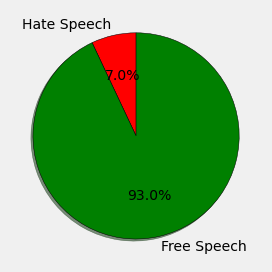

In [26]:
# Visualize the Label Class
speech = [hate_speech, free_speech]
label = ["Hate Speech", "Free Speech"]

plt.pie(speech, labels = label, shadow = True, wedgeprops = {'edgecolor': 'black'}, 
        autopct = '%1.1f%%', startangle= 90, colors=['red', 'green'])

plt.tight_layout()
plt.show()

<img style="width:70px; height:70px; float:left;" src="https://thumbs.gfycat.com/DisgustingSpiffyIguana-size_restricted.gif"><img style="width:70px; height:70px; float:right;" src="https://thumbs.gfycat.com/DisgustingSpiffyIguana-size_restricted.gif"><h2 style="background-color:black; color:white; text-align:center;"><b><i>Part 2: Data Preprocessing</i></b></h2>

In this part, we did data preprocessing. firstly, we did text cleaning with the help of Regular Expression and then we apply preprocessing operations like Tokenization to make a token of each sentence, then remove stop words like "the", "a", "at" etc and then apply stemming to reducing a word to its word stem. After that, we apply the IF-IDF model for feature extraction and we took 2000 most frequent words from dictionaries. In the end, we split our data for training and testing. And ratio for training and testing is 0.8 and 0.2 respectively. 
    
### <font color = #27C3E5> 2.1: </font> <font color = #41EA46> Text Cleaning </font>
> <b>Lowercase <br> Remove Punctuation <br> Remove Urls <br> Removing @tags <br> Remove Special Characters </b>

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

#### <font color = blue>2.1.1: Lower Case

In [27]:
def lower_case(text):
    return text.lower()

df['tweet'] = df['tweet'].apply(lower_case)

#### <font color = blue>2.1.2: Remove Punctuation

In [28]:
def remove_punct(text):
    return text.translate(str.maketrans('','',string.punctuation))

df['tweet'] = df['tweet'].apply(remove_punct)

#### <font color = blue>2.1.3: Remove URLs

In [29]:
def remove_punct(text):
    return text.translate(str.maketrans('','',string.punctuation))

df['tweet'] = df['tweet'].apply(remove_punct)

#### <font color = blue>2.1.4: Removing @tags

In [30]:
def remove_tag(text):
    newtext= re.sub(r'(@[A-Za-z0-9]+)',"",text)
    return newtext

df['tweet'] = df['tweet'].apply(remove_tag)

#### <font color = blue>2.1.5: Remove Special Characters

In [31]:
def remove_special(text):
    return " ".join(e for e in text.split() if e.isalnum())

df['tweet'] = df['tweet'].apply(remove_special)

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5> 2.2: </font> <font color = #41EA46>  Preprocessing Operations </font>
> <b>Tokenizing <br> Removing Stop Words <br> Lemmatization <b> <br> WordCloud </b>

#### <font color = blue>2.2.1: Tokenizing

In [35]:
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
def tokenize(text):
    text = word_tokenize(text)
    return text

df['tweet'] = df['tweet'].apply(tokenize)

#### <font color = blue>2.2.2: Removing StopWords

In [39]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [40]:
def remove_stop(text):
    text  = [i for i in text if not i in stopwords.words('english')]
    return text

df['tweet'] = df['tweet'].apply(remove_stop)

#### <font color = blue>2.2.3: Lemmatization

In [43]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [44]:
def Lemmatize(text):
    word_lem = WordNetLemmatizer()
    text = [word_lem.lemmatize(token) for token in text]
    return text

df['tweet'] = df['tweet'].apply(Lemmatize)

#### <font color = blue>2.2.4: WordCloud

In [50]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

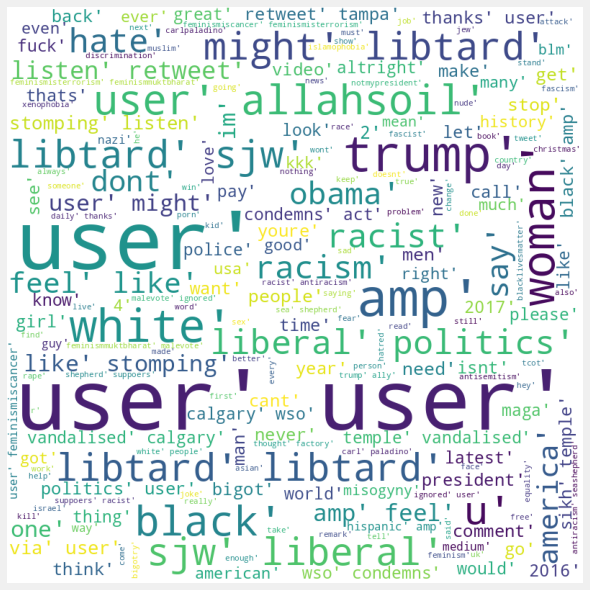

In [51]:
# WordCloud of Hate speech
hate_speech = df[df['label'] == 1]   
comment_words = ''
stopwords = set(STOPWORDS)
for val in hate_speech.tweet:
     
    #typecaste each val to string
    val = str(val)
 
    #split the value
    tokens = val.split()
     
    #Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

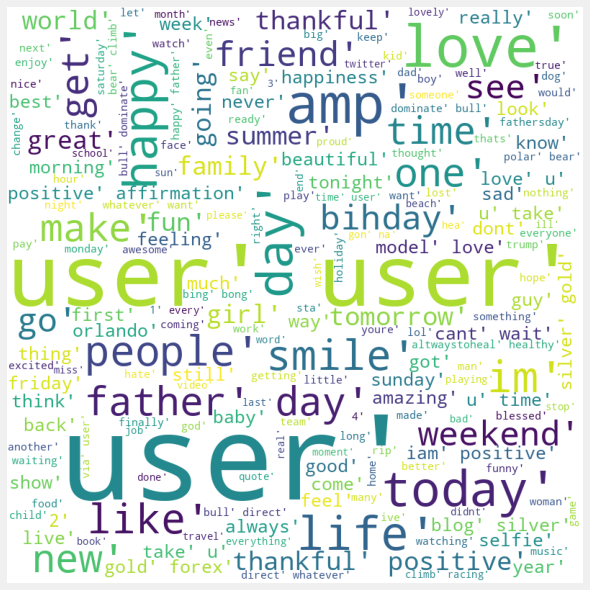

In [52]:
# WordCloud of free speech
free_speech = df[df['label'] == 0]   
comment_words = ''
stopwords = set(STOPWORDS)
for val in free_speech.tweet:
     
    #typecaste each val to string
    val = str(val)
 
    #split the value
    tokens = val.split()
     
    #Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5> 2.3: </font> <font color = #41EA46>  Feature Extraction </font>
<font color = blue><b>2.3.1: TF-IDF Model </b> <br> 

In [53]:
# import TF-IDF model from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
# init the TF-IDF model and take 5000 most frequent words from dictionaries
vectorizer = TfidfVectorizer(max_features= 2000)

In [55]:
# remove the list inside tweet cols which was create due to tokenization
list_to_str = []
for lists in df['tweet']:
    list_to_str.append(' '.join(map(str, lists)))

df['tweet'] = list_to_str

In [56]:
# # fit corpus data into Tf-IDF Model
corpus = df['tweet']
text = vectorizer.fit_transform(corpus).toarray()

In [57]:
# Shape of predictor after Feature Engineering
text.shape

(31962, 2000)

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5> 2.4: </font> <font color = #41EA46>  Split the Dataset </font>

In [58]:
from sklearn.model_selection import train_test_split

#### <font color = blue>2.4.1: Split the dataset into Train and Test

In [59]:
label = df.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(text, label, test_size=0.2, random_state=0)

#### <font color = blue>2.4.2: Training Data

In [60]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)

X_train (25569, 2000)
y_train (25569,)


#### <font color = blue>2.4.3: Testing Data

In [61]:
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_test (6393, 2000)
y_test (6393,)


<img style="width:70px; height:70px; float:left;" src="https://www.pinclipart.com/picdir/big/163-1639462_work-pc-sticker-pc-gif-transparent-clipart.png"><img style="width:70px; height:70px; float:right;" src="https://www.pinclipart.com/picdir/big/163-1639462_work-pc-sticker-pc-gif-transparent-clipart.png"><h2 style="background-color:black; color:white; text-align:center;"><b><i>Part 3: Build the SVM Model </i></b></h2>
    

In this part, we build our model to predict hate and free speech. we implement Support Vector Machine using Scikit-Learn.

In Support Vector Machine we separate a data point into class attribute using hyperplane to separate our data.

In this technique, we lot each data item as a point in n-dimensional space(where n is the number of features you have) with the value of a particular coordinate. Then we perform classification by finding the hyperplane that differentiates the two classes very well.

[Click to see my article on Support Vector Machine](https://medium.com/machine-learning-researcher/support-vector-machine-a57e575b05bb)

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5> 3.1: </font> <font color = #41EA46>  Support Vector Machine with Scikit-Learn </font>

#### <font color = blue>3.1.1: Import the Model from Sklearn

In [62]:
from sklearn.svm import SVC 

#### <font color = blue>3.1.2: Initialize the SVM Model

In [63]:
svm = SVC(kernel = 'linear', random_state= 0) 

#### <font color = blue>3.2.3: Fit the Training Data into SVM  Model

In [64]:
svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

#### <font color = blue>3.2.4: Predict the Train and Test Data

In [65]:
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

#### <font color = blue>3.2.5: Check the Accuracy of Train and Test

In [66]:
from sklearn.metrics import accuracy_score
Accuracy_train = accuracy_score(y_pred_train, y_train)
Accuracy_test = accuracy_score(y_pred_test, y_test)
print(f"Training Accuracy is {Accuracy_train}")
print(f"Test Accuracy is {Accuracy_test}")

Training Accuracy is 0.9598341741953147
Test Accuracy is 0.9577663068981699


<img style="width:70px; height:70px; float:left;" src="https://thumbs.gfycat.com/ResponsibleUnfinishedAlpinegoat-size_restricted.gif"><img style="width:70px; height:70px; float:right;" src="https://thumbs.gfycat.com/ResponsibleUnfinishedAlpinegoat-size_restricted.gif"><h2 style="background-color:black; color:white; text-align:center;"><b><i> Part 4: Result Evaluation </i></b></h2>

In this part, we evaluate the result of our model. First, we visualize the confusion matrix and see the incorrect predictand and then we calculate the following score ("Accuracy", "Precision", "TPR", "FPR", "F-Score", "Specificity", "Error" and "Roc Area") and visualize them.

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5> 4.1: </font> <font color = #41EA46>  Confusion Matrix </font>

In [67]:
from sklearn.metrics import confusion_matrix

#### <font color = blue>4.1.1: Create and Visualize Confusion Matrix

<AxesSubplot:>

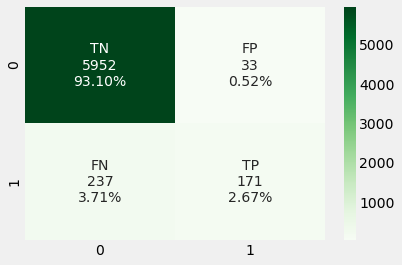

In [68]:
# Create the Confusion Matrix
confusion_matrix = confusion_matrix(y_test, y_pred_test)

#[row, column]
TP = confusion_matrix[1, 1]        
TN = confusion_matrix[0, 0]           
FP = confusion_matrix[0, 1]           
FN = confusion_matrix[1, 0]


# Visualize the Matrix
group_names = ['TN','FP','FN','TP']

group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Greens')

### <font color = #27C3E5> 4.2: </font> <font color = #41EA46>  Evaluate the Results </font>

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, roc_auc_score

#### <font color = blue>4.2.1: Calculate the Results

In [70]:
# Accuracy Score
Accuracy = accuracy_score(y_test, y_pred_test)
print('Accuracy Score:', Accuracy) 

# Precision Score
Precision = precision_score(y_test, y_pred_test)
print('Precision Score:', Precision)   

# True positive Rate (TPR) or Sensitivity or Recall
TPR = recall_score(y_test, y_pred_test)
print('True positive Rate:', TPR)             

# False positive Rate (FPR)
FPR = FP / float(TN + FP)
print('False positive Rate', FPR)                       

# F1 Score or F-Measure or F-Score
F1 = f1_score(y_test, y_pred_test)
print('F1 Score:', F1)                 

# Specificity
Specificity = TN / (TN + FP)
print('Specificity:', Specificity )                    

# Mean Absolute Error
Error = mean_absolute_error(y_test, y_pred_test)
print('Mean Absolute Error:', Error)   

# ROC Area
Roc = roc_auc_score(y_test, y_pred_test)
print('ROC Area:', Roc) 

Accuracy Score: 0.9577663068981699
Precision Score: 0.8382352941176471
True positive Rate: 0.41911764705882354
False positive Rate 0.005513784461152882
F1 Score: 0.5588235294117647
Specificity: 0.9944862155388471
Mean Absolute Error: 0.04223369310183012
ROC Area: 0.7068019312988353


#### <font color = blue>4.2.2: Visualize the Results

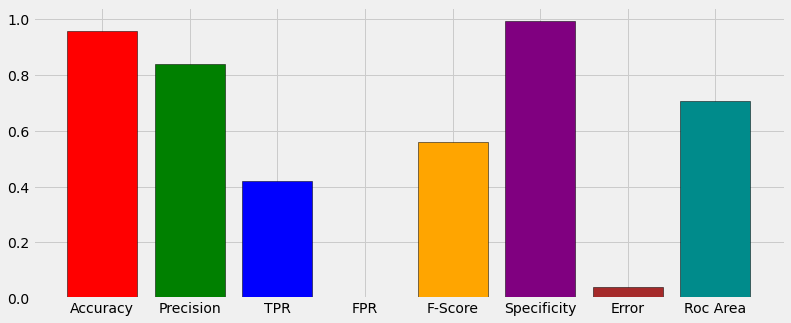

In [71]:
plt.figure(figsize = (12, 5))

result = [Accuracy, Precision, TPR, FPR, F1, Specificity, Error, Roc]
label = ["Accuracy", "Precision", "TPR", "FPR", "F-Score", "Specificity", "Error", "Roc Area"]
colors=[ 'red', 'green', 'blue', 'darkgoldenrod', 'orange', 'purple', 'brown', 'darkcyan']

plt.bar(label, result, color = colors, edgecolor='black')
plt.show()

<img style="width:70px; height:70px; float:left;" src="https://cliply.co/wp-content/uploads/2019/05/371905140_MEET_ROBOT_400px.gif"><img style="width:70px; height:70px; float:right;" src="https://cliply.co/wp-content/uploads/2019/05/371905140_MEET_ROBOT_400px.gif"><h2 style="background-color:black; color:white; text-align:center;"><b><i> Part 5: Make a New Prediction</i></b></h2>
<br>
In the last part, we save our model using the pickle library and then use the save model file for new prediction.

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5> 5.1: </font> <font color = #41EA46> Save the TF-IDF Vectorizer and SVM Model </font>

#### <font color = blue>5.1.1: Import Pickle Library to Save the File

In [73]:
import pickle 

#### <font color = blue>5.1.2: Save the TF-IDF Vectorizer and store into model s3 bucket

In [75]:
TF_IDF= open("cv.pkl","wb")          
pickle.dump(vectorizer,TF_IDF)                                  
TF_IDF.close()   

In [76]:
my_region = boto3.session.Session().region_name 
print(my_region)

us-east-1


In [94]:
bucket_name2 = 'ml-application-model-storage'
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name2)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [95]:
prefix2 = 'Save Model'
output_path2 ='s3://{}/{}/output'.format(bucket_name2, prefix2)
print(output_path2)

s3://ml-application-model-storage/Save Model/output


In [99]:
boto3.Session().resource('s3').Bucket(bucket_name2).Object(os.path.join(prefix2, 'cv.pkl')).upload_file('cv.pkl')
s3_model = sagemaker.TrainingInput(s3_data='s3://{}/{}/'.format(bucket_name2, prefix2), content_type='csv')

In [100]:
s3_model

#### <font color = blue>5.1.3: Save the SVM model and store into s3 bucket

In [101]:
Support_Vector_Machine = open("model.pkl","wb")          
pickle.dump(svm,Support_Vector_Machine)                                  
Support_Vector_Machine.close() 

In [102]:
boto3.Session().resource('s3').Bucket(bucket_name2).Object(os.path.join(prefix2, 'model.pkl')).upload_file('model.pkl')
s3_model= sagemaker.TrainingInput(s3_data='s3://{}/{}/'.format(bucket_name2, prefix2), content_type='csv')

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5> 5.2: </font> <font color = #41EA46> Load the TF-IDF Vectorizer and SVM Model </font>

#### <font color = blue>5.2.1: Load the TF-IDF Vectorizer

In [103]:
cv = open("cv.pkl","rb")           
cv = pickle.load(cv)                                 
cv

TfidfVectorizer(max_features=2000)

#### <font color = blue>5.2.2: Load the SVM Model

In [104]:
model = open("model.pkl","rb")           
model = pickle.load(model)                                 
model

SVC(kernel='linear', random_state=0)

![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

### <font color = #27C3E5> 5.3: </font> <font color = #41EA46> Make a new Prediction </font>                                

#### <font color = blue>5.3.1 hate Speech prediction example

In [105]:
# Positive News example
comment = ["I support racism. I don't care"]
vect = cv.transform(comment).toarray()
model.predict(vect)

if model.predict(vect) == 1:
    print("Hate Speech")
else:
    print("Free Speech")

Hate Speech


#### <font color = blue>5.3.2 free Speech prediction example

In [106]:
# Positive News example
comment = [" I respect the all kind of nationalities"]
vect = cv.transform(comment).toarray()
model.predict(vect)

if model.predict(vect) == 1:
    print("Hate Speech")
else:
    print("Free Speech")

Free Speech


![Machine Learning Project](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

#### © Amir Ali